## Import Required Libraries

In [6]:
from matplotlib import pyplot as plt
import networkx as nx
from qbraid_algorithms.qaoa import QAOA
import pyqasm

from qiskit_qasm3_import import parse
from qiskit_ibm_runtime import Session, Sampler as Sampler, Estimator
from qiskit_aer import AerSimulator
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
import numpy as np
from typing import Sequence

## Graph definition for max-cut problem

The Max-Cut problem is an optimization problem that is hard to solve (more specifically, it is an _NP-hard_ problem) with a number of different applications in clustering, network science, and statistical physics. This example considers a graph of nodes connected by edges, and aims to partition the nodes into two sets such that the number of edges traversed by this cut is maximized.


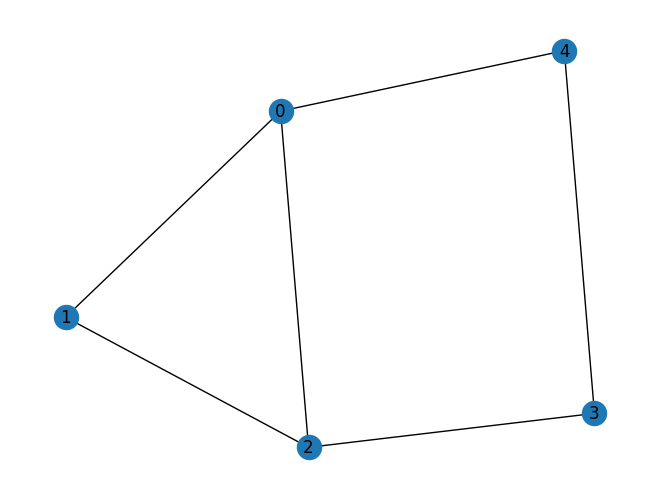

In [7]:
edges = [(0, 1), (0, 2), (0, 4), (1, 2), (2, 3), (3, 4)]
graph = nx.Graph(edges)
positions = nx.spring_layout(graph, seed=1)

nx.draw(graph, with_labels=True, pos=positions)
plt.show()

## Compute cost function
In this case the *Qiskit* object are used to calculate the cost but it can be done with custom methods

In [8]:
def build_max_cut_paulis(graph: nx.Graph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.
 
    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for i,j in graph.edges:
        pauli_list.append(("ZZ", [i, j], 1))
    return pauli_list

n = 5
max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, n)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


## Create cost function
Here we create two different cost functions, one for getting the counts that uses the *Sampler* primitive for retreiving the counts and the *Estimator* to calculate the cost

In [9]:
def cost_function_res(params):
    qaoa = QAOA(5, use_input=False)
    qaoa.setup_maxcut(graph=graph)
    program = qaoa.generate_algorithm(3, param=params)
    module = pyqasm.loads(program)
    module.unroll()
    loaded_circuit = parse(pyqasm.dumps(module))
    aer_sim = AerSimulator()
    with Session(backend=aer_sim):
        sampler = Sampler()
        sampler.options.dynamical_decoupling.enable = True
        sampler.options.dynamical_decoupling.sequence_type = "XY4"
        sampler.options.twirling.enable_gates = True
        sampler.options.twirling.num_randomizations = "auto"
        result = sampler.run([loaded_circuit], shots=10000).result()
    return result[0].data.cb.get_counts(), result[0].data.cb.get_int_counts()

In [10]:
objective_func_vals = []
def cost_function(params):
    qaoa = QAOA(5, use_input=False)
    qaoa.setup_maxcut(graph=graph)
    program = qaoa.generate_algorithm(3, param=params)
    module = pyqasm.loads(program)
    module.unroll()
    loaded_circuit = parse(pyqasm.dumps(module))
    aer_sim = AerSimulator()
    with Session(backend=aer_sim) as session:
        sampler = Estimator(mode=session)
        sampler.options.default_shots = 20000
        pub = (loaded_circuit, cost_hamiltonian, [])
        result = sampler.run([pub]).result()
    cost = result[0].data.evs
    objective_func_vals.append(cost)
    return cost

## Define initial parameters and minimize the cost function

In [11]:
initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_beta, initial_beta, initial_beta, initial_gamma, initial_gamma, initial_gamma]
result = minimize(
        cost_function,
        init_params,
        method="COBYLA",
        tol=1e-2,
    )
print(result)

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -2.2875
       x: [-2.921e-01  2.782e+00  2.051e+00  4.779e+00  2.335e+00
            3.005e+00]
    nfev: 57
   maxcv: 0.0


## Visualization of the cost vs iterations during minimization

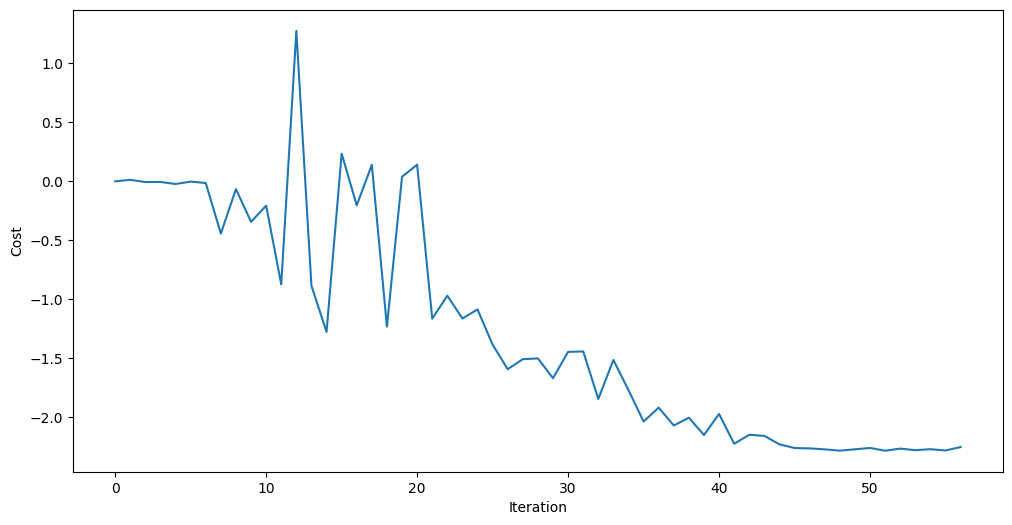

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

## Output distribution with initial parameters

C:\Users\cical\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:273: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


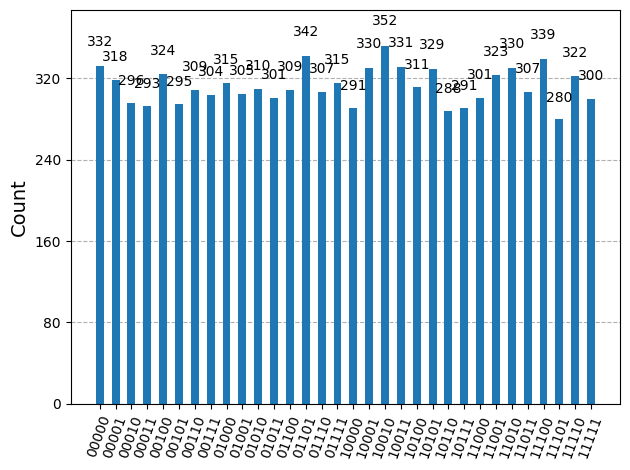

In [13]:
res_bin, res_int = cost_function_res(init_params)
plot_histogram(res_bin)

In [14]:
res_bin, res_int = cost_function_res(result.x)
shots = 10000
final_distribution_bin = {key: val / shots for key, val in res_bin.items()}
final_distribution_int = {key: val / shots for key, val in res_int.items()}
print(final_distribution_int)

{5: 0.0609, 19: 0.0442, 18: 0.0559, 22: 0.1022, 11: 0.1019, 14: 0.0457, 26: 0.0612, 12: 0.0444, 9: 0.102, 17: 0.0456, 3: 0.0034, 21: 0.0578, 10: 0.053, 20: 0.1043, 13: 0.0594, 29: 0.0029, 1: 0.0067, 4: 0.005, 27: 0.0059, 7: 0.0035, 25: 0.003, 0: 0.0019, 28: 0.0038, 15: 0.0021, 23: 0.0027, 16: 0.0021, 2: 0.0029, 6: 0.003, 30: 0.0055, 24: 0.0029, 31: 0.0022, 8: 0.002}


C:\Users\cical\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:273: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [15]:
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]
 
 
keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()
 
print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 0, 1, 0, 1]


## Output distribution after optimization

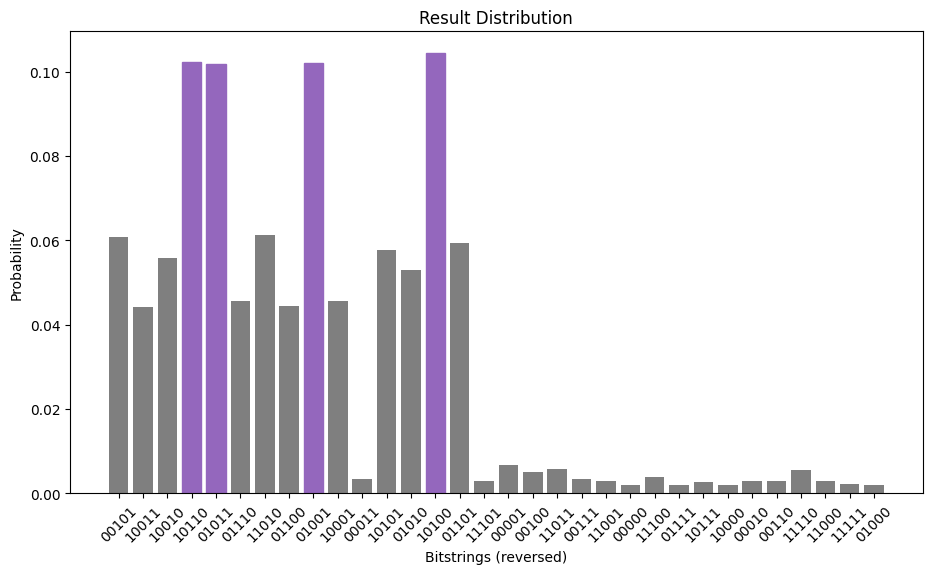

In [16]:
plt.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p[0])].set_color("tab:purple")
plt.show()

In [17]:
for p in positions:
    print(list(final_bits.keys())[p[0]])

10100
10110
01001
01011


In [18]:
def evaluate_sample(x: Sequence[int], graph: nx.Graph) -> float:
    assert len(x) == len(
        list(graph.nodes())
    ), "The length of x must coincide with the number of nodes in the graph."
    return sum(
        x[u] * (1 - x[v]) + x[v] * (1 - x[u])
        for u, v in list(graph.edges)
    )

In [19]:
cut_value = evaluate_sample(most_likely_bitstring, graph)
print("The value of the cut is:", cut_value)

The value of the cut is: 5


In [20]:
for p in positions:
    result = list(final_bits.keys())[p[0]]
    bin = [int(digit) for digit in result]
    bin.reverse()
    cut_value = evaluate_sample(bin, graph)
    print("The value of the cut is:", cut_value)
    #print(list(final_bits.keys())[p[0]])

The value of the cut is: 5
The value of the cut is: 5
The value of the cut is: 5
The value of the cut is: 5


In [21]:
# results from https://quantum.cloud.ibm.com/docs/en/tutorials/quantum-approximate-optimization-algorithm
result = ["01011", "10101", "10110", "11000"]
for r in result:
    bin = [int(digit) for digit in r]
    bin.reverse()
    cut_value = evaluate_sample(bin, graph)
    print("The value of the cut is:", cut_value)

The value of the cut is: 5
The value of the cut is: 4
The value of the cut is: 5
The value of the cut is: 2
